# Exploring FLIM Towards Semantic Segmentation

> This notebook covers the necessary steps to experiment with a FLIM and a U-Net architecture, visualizing its activations. We will use FLIM to learn our encoder.

We will approach the following:

1. Split our data into training and testing;
2. Configure a dataset;
3. Configure our dataset as a data loader to provide data ingestion during the training phase;
4. Define a fully convolutional network (U-Net);
5. Define a method to load FLIM-Encoder into our U-Net model
6. Learning rate schedulers;
7. Define a training loop;
8. Define a testing loop;
9. Run training experiments and test our model;
10. Run inferences with FLIM-Encoder using an adaptive decoder.

## 1. Split data into training and testing sets

Let us first define our dataset; we will explore the parasite egg dataset towards 2D segmentation. The eggs are from Schistosoma Mansoni. The cell below imports the necessary libraries.

In [1]:
# Necessary libraries
from pathlib import Path, PosixPath
import os
from tqdm import tqdm
from typing import List, Union
import json

from PIL import ImageOps
from tifffile import imsave
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch_snippets

from skimage.color import lab2rgb

First, we need to define the path to our dataset. We are using the reshaped parasite dataset (images and labels have a shape of 240x240 pixels with three channels). To run our experiments, we need to use either a GPU (DEVICE) or a CPU ("cpu"); for such, we set the DEVICE variable.

We will also define the path to a JSON file which specifies our encoder architecture, and a folder with our endoder's weights.

In [2]:
DATA_PATH = Path("../data/parasites")
ORIG_PATH = DATA_PATH / Path("all_images")
LABELS_PATH = DATA_PATH / Path("all_truelabels")
DEVICE = "cuda"

ARCH_JSON = Path(
    DATA_PATH / Path("flim_data/arch2d_seg.json")
)
WEIGHTS_PATH = Path(
    DATA_PATH / Path("flim_data/model_bias")
)

# Reads architecture dict to define our network
with open(ARCH_JSON, "r") as json_data:
    arch_description = json.load(json_data)

Our dataset contains 96 images. We will further divide it into training and testing images. We will use ~80% to train (76) and ~20% to test (20) the model. You may modify the n_train variable (currently derived using 80% - 0.8 - to adjust train and test size).

In [3]:
images = os.listdir(ORIG_PATH)
images.sort()
labels = images

# 80% of train and 20% of test
n_train = int((0.8 * len(images)))

# Train Data (File Names)
train_images = images[:n_train]
train_labels = images[:n_train]
# Test Data (File Names)
test_images = images[n_train:]
test_labels = images[n_train:]

## 2. Configure a dataset

Now, we need to define the Dataset class. It must:

- Enable training and testing with a single image (If we want to train with a single image - Overfit). In this case, we set the parameter `image_id` to a number (e.g., 0);
- Enable training and testing using the data splits. In this case, we set the parameter `image_id` to `None`.

First, to efficiently load LAB images we will use our C library (ift) through a python wrapper ([pyift](https://github.com/LIDS-UNICAMP/pyift)). To load our image using pyift, we will use the python package [FLIM](https://github.com/LIDS-UNICAMP/FLIM), which bundles other useful methods to develop convolutional models using FLIM.

In [4]:
# Import FLIM utils to load images as lab
from flim.experiments._image_utils import load_image

We start by importing the necessary libraries. As FLIM works with images in the LAB space, we also need to convert our images from RGB to LAB.

In [5]:
class SegDataset(Dataset):
    def __init__(
        self,
        images_path: PosixPath, # Path to images
        labels_path: PosixPath, # Path to labels
        images: List[str], # List of images
        labels: List[str], # List of labels
        image_id: int = None # Image ID if training with a single image
    ):
        self.images_path = [images_path / Path(image) for image in images]
        self.labels_path = [labels_path / Path(label) for label in labels]
        self.image_id = image_id

        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32)
        ])  

    def __len__(self):
        # If image id not provided, we are training with the whole dataset
        if self.image_id == None:
            return len(self.images_path)
        else:
            return 1

    def __getitem__(self, idx):
        if self.image_id == None:
            image_path = self.images_path[idx]
            label_path = self.labels_path[idx]
        else:
            image_path = self.images_path[self.image_id]
            label_path = self.labels_path[self.image_id]
        
        image = load_image(str(image_path), lab=True)
        image = self.transforms(image)
        
        label = ImageOps.grayscale(Image.open(label_path))
        label = self.transforms(label)
        
        # Tackles label as a two channel prediction (Background and Foreground)
        background = torch.zeros(1, label.shape[1], label.shape[2])
        foreground = torch.zeros(1, label.shape[1], label.shape[2])
        background[label == 0] = 1
        foreground[label == 1] = 1
        label = torch.cat([background, foreground], axis=0)

        return image, label

Now, let us visualize the output of our dataset object for a single image. The method `visualize_dataset_item` enables us to visualize an image of our dataset.

Notice that it generates two masks, one for our foreground (parasite egg) and the other for the background.

In [6]:
# Method to visualize Dataset Item (LAB)
def visualize_dataset_item(dataset, item):
    img, label = dataset.__getitem__(item)
    img = img.permute(1, 2, 0)
    img[:,:, 0] = img[:,:, 0] * 99.998337
    img[:,:, 1] = img[:,:, 1] * (86.182236 + 98.258614) - 86.182236
    img[:,:, 2] = img[:,:, 2] * (107.867744 + 94.481682) - 107.867744
    img = lab2rgb(img)

    plt.subplot(131)
    plt.yticks([]),plt.xticks([])
    plt.title("Image")
    plt.imshow(img)
    plt.subplot(132)
    plt.yticks([]),plt.xticks([])
    plt.title("Background")
    plt.imshow(label[0], cmap="gray")
    plt.subplot(133)
    plt.yticks([]),plt.xticks([])
    plt.title("Foreground")
    plt.imshow(label[1], cmap="gray")

Then, we define our dataset using all training and testing data.

In [7]:
# DATASETS - TRAIN AND TEST
train_dataset = SegDataset(
    images_path=ORIG_PATH,
    labels_path=LABELS_PATH,
    images=train_images,
    labels=train_labels,
    image_id=None
)
test_dataset = SegDataset(
    images_path=ORIG_PATH,
    labels_path=LABELS_PATH,
    images=test_images,
    labels=test_labels,
    image_id=None
)

Test the method `visualize_dataset_item` to visualize different images (change the `dataset` and `item` parameters).

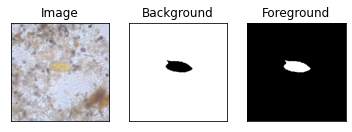

In [8]:
visualize_dataset_item(train_dataset, 1)

## 3. Configure our dataset as a dataloader

Through PyTorch data loader ([`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)), we configure our dataset as a data loader by using:

- A Dataset (Our Train and Test datasets);
- A batch size (Number of images used to update the model's parameters);
- If we want to shuffle our data at each epoch (We see images in different orders for each epoch).

In [9]:
# DATALOADERS - TRAIN AND TEST
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Visualizes shape of a batch sampled from train dataloder
sample_train_images, sample_train_labels = next(iter(train_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)

Images shape =>  torch.Size([4, 3, 240, 240])
Labels shape =>  torch.Size([4, 2, 240, 240])


## 4. Define a fully convolutional network (U-Net)

Now, we have a dataloader working. It is responsible for feeding data, both the input image and the parasite egg's segmentation mask, to a deep learning model. We expect that, given an input image, our model will learn to segment the parasite egg, if any.

Now, the following cells define our deep-learning model, a U-Net architecture (**see the image below**). We also enable our model to store the activation maps for visual analysis.

U-Net architectures have two parts: an encoder (left part) and a decoder (right part). The encoder extracts image features at different levels while the encoder combines those extracted features to detect and segment.

![](arch_sample_flim.png)

Let us first define some methods to help us:

- **up_conv:** Implements our **ConvTranspose2d** convolutions, responsible for upsampling our features in the decoder;
- **Conv:** Implements our **Conv2D** in decoders;
- **init_weights:** Initializes our model's parameters, using Xavier uniform for convolution's weights and setting biases to 0.01.

In [10]:
# Utilitarians blocks for UNet Decoder
# Upsamples input feature map
def up_conv(in_channels, out_channels, kernel_size=2, padding=0, stride=2, output_padding=0):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, output_padding=output_padding),
        nn.ReLU(inplace=True)
    )
    
# Defines convolutional blocks for our decoder
def conv(in_channels, out_channels, kernel_size, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    
# Initializes kernel weights
def init_weights(m):
    if (isinstance(m,nn.Conv2d) or (isinstance(m,nn.ConvTranspose2d))):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

Now, the class UNet defines our U-Net architecture:

1. On the **__init__** method, we first set a random_seed to guarantee reproducibility. Then, we define our encoder blocks (block1, and block2), our bottleneck, and finally, our decoder (up_convs + dec_convs and the pred convolution, which outputs our segmentation mask);
2. Our **forward** method is responsible for passing the input image through the model architecture until we get the parasite egg's mask at the end;
3. **write_activation** and **save_activations** saves activations of each network block for visual inspection;
4. **save_curves** will save the learning curves of our models at the end of our training loop.

To initialize a U-Net model, we must set the following parameters:

- `in_channels:` The number of channels of our input (e.g., 3 for RGB and 1 for Gray);
- `n_kernels:` A list of 3 integer values specifying the number of kernels for each convolutional block (e.g., [8, 16,32]). Those values are used to define both encoder and decoder convolutional blocks;
- `kernel_sizes:` A list of 3 integer values, specifying the kernels' size for each convolutional block (e.g., [3, 3, 3]);
- `activations_path:` A path to save each convolutional block activation. After training, one could navigate into that folder to visualize what kind of features the model is extracting.

In [11]:
class UNet(nn.Module):
    def __init__(
            self, in_channels: int, # RGB or LAB -> 3 Channels
            n_kernels: List[int], # N Kernels by conv block
            kernel_sizes: List[int], # Kernel sizes by conv block
            bottleneck_size: int, # Kernel size for bottleneck
            activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()
        
        # Sets torch seed to guaratee Reproducibility
        random_seed = 7
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        self.activations_path = activations_path
        
        # Encoder Convolutional Blocks
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=n_kernels[0],
                kernel_size=kernel_sizes[0],
                padding=kernel_sizes[0] // 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3, stride=2,
                padding=1
            )
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_kernels[0], out_channels=n_kernels[1],
                kernel_size=kernel_sizes[1],
                padding=kernel_sizes[1] // 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3, stride=2,
                padding=1
            )
        )
        
        # Bottleneck
        self.bottleneck = nn.Conv2d(
            in_channels=n_kernels[1], out_channels=2*n_kernels[1], 
            kernel_size=bottleneck_size, stride=2, padding=bottleneck_size//2
        )
        
        # Decoder
        self.up_conv1 = up_conv(
            in_channels=2*n_kernels[1], out_channels=n_kernels[1]
        )
        self.dec_conv1 = conv(
            in_channels=2*n_kernels[1], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1], padding=kernel_sizes[1] // 2
        )
        self.up_conv2 = up_conv(
            in_channels=n_kernels[1], out_channels=n_kernels[0]
        )
        self.dec_conv2 = conv(
            in_channels=2*n_kernels[0], out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0], padding=kernel_sizes[0] // 2
        )
        self.up_conv_pred = up_conv(
            in_channels=n_kernels[0], out_channels=n_kernels[0]
        )
        self.pred = nn.Conv2d(
            in_channels=n_kernels[0], out_channels=2, kernel_size=1
        )
        
        # Initializes weights
        self.block1.apply(init_weights)
        self.block2.apply(init_weights)
        self.up_conv1.apply(init_weights)
        self.dec_conv1.apply(init_weights)
        self.up_conv2.apply(init_weights)
        self.dec_conv2.apply(init_weights)
        self.up_conv_pred.apply(init_weights)
        self.pred.apply(init_weights)    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Dictionary to keep track of activations
        self.activations = {"encoder": [], "decoder": []}
              
        # Encoder
        x1 = self.block1(x)
        self.activations["encoder"].append(x1)
        x2 = self.block2(x1)
        self.activations["encoder"].append(x2)
        
        # Bottleneck
        bottleneck = self.bottleneck(x2)
        
        # Decoder - torch.cat performs skip connections on decoder
        x = self.up_conv1(bottleneck)
        x = torch.cat([x, x2], dim=1)
        x = self.dec_conv1(x)
        self.activations["decoder"].append(x)
        x = self.up_conv2(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec_conv2(x)
        self.activations["decoder"].append(x)
        x = self.up_conv_pred(x)
        x = self.pred(x)
        
        return x
    
    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)

        image = Image.fromarray(image)
        if reshape:
            image = image.resize((240, 240), Image.Resampling.NEAREST)
        image.save(path)
    
    @torch.no_grad()
    def save_activations(self, epoch: int, data_loader) -> None:
        # Save encoder activations
        activations_path = self.activations_path / Path(f"epoch_{epoch}")
        
        # Save activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        for image_path in tqdm(images_path):
            image_name = os.path.basename(image_path)
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("encoder_reshape") 
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            
            image = load_image(str(image_path), lab=True)
            image_data = data_loader.dataset.transforms(image)
            
            # Adds batch dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to(DEVICE)
            self.to(DEVICE)
            self.forward(image_data)
        
            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations["encoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                )
                    
            # Save decoder activations
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("decoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("decoder_reshape") 
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            for actv_idx, activations in enumerate(self.activations["decoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size imagace
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )

        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))
        
    def save_curves(self, logger: torch_snippets.torch_loader.Report) -> None:
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(['trn_loss'], ax=ax)
        savefig_path = self.activations_path / Path("loss.png")
        plt.savefig(savefig_path)
        
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(['trn_accuracy'], ax=ax)
        savefig_path = self.activations_path / Path("accuracy.png")
        plt.savefig(savefig_path)

## 5. Define a method to load FLIM-Encoder into our U-Net model

Additionally, as we will use a FLIM Encoder as our U-Net encoder, we define methods to load the FLIM Encoder's weight into the U-Net encoder.

The method `load_FLIM_encoder`, receives as parameters:

- `model`: Our U-Net model;
- `arch_json`: The path to a JSON file describing our FLIM-Encoder;
- `weights_path`: The path to a folder with the FLIM-Encoder's weights;
- `channels`: A list specifying the number of input channels (e.g., 3 for RGB) and the number of filters for each encoder convolutional block.

In [12]:
def get_bias(bias_path: PosixPath) -> np.ndarray:
    with open(bias_path, "r") as file:
        n_kernels = file.readline()
        bias = file.readline().strip().split(" ")
    
    bias = np.array(bias).astype(np.float32)
    
    return bias


def shift_weights(weights: np.ndarray, kernel_size: int, in_channels: int) -> np.ndarray:

    nkernels = weights.shape[1]
    
    shifted_weights = np.zeros((nkernels,in_channels,kernel_size[1],kernel_size[0]))    
   
    for k in range(nkernels): 
        for channel in range(in_channels):
            i = channel
            for row in range(kernel_size[1]):
                for col in range(kernel_size[0]):
                    shifted_weights[k][channel][row][col] = weights[i][k]
                    i = i + in_channels

    return shifted_weights


def get_weights(kernel_path: PosixPath,  kernel_size: int, in_channels: int) -> np.ndarray:
    weights = np.load(kernel_path)
    weights = shift_weights(weights, kernel_size, in_channels)
    
    return weights

def load_FLIM_encoder(model: UNet, arch_json: PosixPath, weights_path: PosixPath, channels: List[int]) -> None:
    with open(arch_json, "r") as json_data:
        arch_description = json.load(json_data)
    
    n_layers = arch_description["nlayers"]
    
    in_channels = channels[0]
    print("[INFO] Loading FLIM Encoder")
    for n in range(1, n_layers + 1):
        out_channels = channels[n]

        print(f"[INFO] Loading Layer {n} weights")
        # Gets each encoder Block to set its weights and biases
        model_block = getattr(model, f"block{n}")
        
        # Sets its biases
        bias_path = weights_path / Path(f"conv{n}-bias.txt")
        kernel_path = weights_path / Path(f"conv{n}-kernels.npy")
        # Get biases and set to model - Accessing conv block biases
        bias = get_bias(bias_path)
        bias = nn.Parameter(torch.from_numpy(bias).float())
        model_block[0].bias.data = bias.to(DEVICE)
        
        # Get kernel weights and set to model - Accessing conv block weights
        kernel_size = arch_description[f"layer{n}"]["conv"]["kernel_size"]
        weights = get_weights(kernel_path, kernel_size, in_channels)
        weights = nn.Parameter(torch.from_numpy(weights).float())
        model_block[0].weight.data = weights.to(DEVICE)
        
        in_channels = channels[n]

## 6. Learning rate scheduler

Fine-tuning an architecture already trained with an untrained decoder running the first epochs with a small learning rate is helpful. As the first epochs using an untrained decoder will result in higher errors, a lower learning rate scheduler avoids "forgetting" what the FLIM-Encoder has already learned.

The cell below shows how to define and use a learning rate scheduler.

In [13]:
# Import necessary libraries
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [14]:
# create a simple model 
model = nn.Sequential(
    nn.Linear(34, 34),
    nn.ReLU(),
    nn.Linear(34, 1),
    nn.Sigmoid()
)

lr=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()
# Start Factor of the optimizer learning rate
# End factor of the optimizer learning rate
# Total iterations to increase from Start to End Factor
scheduler = lr_scheduler.LinearLR(
    optimizer, start_factor=1e-3, end_factor=1,
    total_iters=400, verbose=False
)

# List to plot our results
lrs = []
epochs = []

for epoch in range(1000):
    lr = scheduler.get_last_lr()
    epochs.append(epoch+1)
    lrs.append(lr)
    optimizer.step()
    scheduler.step()

The cell below shows our learning rate across 1000 training epochs.

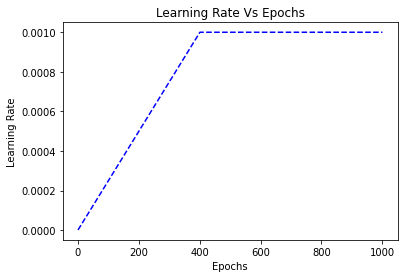

In [15]:
plt.plot(epochs, lrs, "b--")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Vs Epochs")
plt.show()

## 7. Define a training loop

We have everything prepared in our pipeline; we lack a training loop that will feed data from the data loader to our model and use the model's prediction to compute loss and update the model's parameter.

Furthermore, as we are using a FLIM-Encoder, we want our training loop to have two additional features:

- **Freeze the Encoder's Weights**: In this case, we do not learn the encoder; our training loop updates the decoder's parameters.
- **Train with a Learning Rate Scheduler:** We use a learning rate scheduler to optimize the encoder's weights.

First, we import the necessary libraries.

In [16]:
from torch_snippets import optim, Report
from torchsummary import summary
import monai
from monai.losses import DiceLoss, DiceFocalLoss
import cv2

2023-11-20 19:51:20.089674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 19:51:20.231206: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 19:51:20.690905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/cv2/../../lib64::/home/afalcao/software/Elastix/lib:/usr/local/cuda/lib64:/home/afalcao/Qt/6.3.1/gcc_64/lib:/home/afalcao/software/FeTS
2023-11-20 

Secondly, we define a loss function which we want to optimize. Those loss functions were calculated by comparing the model's prediction with the ground-truth segmentation mask. To optimize those loss functions is to produce better segmentation masks.

Below, we made avaialable the following losses:

- [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)
- [BCE](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss)
- [DiceLoss](https://docs.monai.io/en/stable/losses.html)

> See our slide decks and the link provided for further details.

In [17]:
loss_fuctions = {
    "mse": nn.MSELoss(),
    "bce": nn.BCELoss(),
    "dice": DiceLoss(sigmoid=True, batch=True),
}

Now, we define our loss class. It is responsible for computing the loss for both masks (background and foreground), but it also enables us to set different weights for each mask.

To configure it, we must:

- Provide a loss function from the dictionary above (`loss_fn parameter`);
- Set the `weights` parameters as a list with weights for each class.

In [18]:
class Loss(nn.Module):
    def __init__(
            self,
            loss_fn,
            weights: List[float] = [1.0, 1.0]
        ):
        super().__init__()
        self.loss_fn = loss_fn
        self.background_weight = weights[0]
        self.foreground_weight = weights[1]

    def forward(self, y_pred, y_true):
        background_loss = self.loss_fn(y_pred[:,0, ...], y_true[:, 0, ...])
        foreground_loss = self.loss_fn(y_pred[:,1, ...], y_true[:, 1, ...])
        background_loss *= self.background_weight
        foreground_loss *= self.foreground_weight
        loss = background_loss + foreground_loss
        return loss

Finally, we define our training loop. For such, we must provide:

- The number of epochs to train our model;
- Our U-Net model;
- A data loader;
- The name of our loss_function (e.g., "mse", "bce");
- Our learning rate (lr), which controls the size of updates in the models' parameters. A too-high value will cause instability, while a too-low value will result in slower training;
- A list with weights for background and foreground (e.g., [1, 1]).
- The `freeze_encoder` parameter. `False` allows our training loop to update the encoder's weights, while `True` does not allow it.
- The `use_lr_scheduler` parameter. `True` allows our training loop to use a learning rate scheduler, while `True` uses a fixed learning rate.

> The N_SAVE_ACTIVATIONS variable controls when we save our convolution activations. For instance, currently, it writes activations for every 200 epochs.

In [19]:
N_SAVE_ACTIVATIONS = 100
def train_loop(
        epochs, model, dataloader, lr, loss_function, weights,
        freeze_encoder=False, use_lr_scheduler=False
    ):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if use_lr_scheduler:
        scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-1, end_factor=1, total_iters=10, verbose=False)
    model.to(DEVICE)
    
    # Freeze encoder weights
    if freeze_encoder:
        model.block1.requires_grad_(False)
        model.block1.trainable = False
        model.block2.requires_grad_(False)
        model.block2.trainable = False
    
    logger = Report(epochs)
    loss = Loss(loss_function, weights)

    for epoch in range(epochs):
        losses = []
        accuracies = []
        for batch in dataloader: # In our case, a single image, or 3
            model.train()
            image, ground_truth = batch
            image = image.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)
            prediction = model(image)
            optimizer.zero_grad()

            # Computes loss and accuracy
            prediction = torch.sigmoid(prediction)
            loss_value = loss(prediction, ground_truth)

            accuracy = (
                (prediction[:,1,...] > prediction[:,0,...]) == ground_truth[:,1,...]
            ).float().mean()
            
            losses.append(loss_value)
            accuracies.append(accuracy)

            loss_value.backward()
            optimizer.step()
        
        # At the end of the epoch, we take a step in our LR Scheduler
        if use_lr_scheduler:
            scheduler.step()
        
        mean_loss = torch.mean(torch.Tensor(losses))
        mean_acc = torch.mean(torch.Tensor(accuracies))
        logger.record(
            epoch + 1,
            trn_loss=mean_loss.item(),
            trn_accuracy=mean_acc.item()
            )
        if ((epoch + 1) % N_SAVE_ACTIVATIONS) == 0:
            model.save_activations(epoch, dataloader)

    model.save_curves(logger)

## 8. Define a testing loop

First, we import necessary libraries

In [20]:
from medpy.metric import binary
from torchmetrics import JaccardIndex
np.bool = np.bool_

The cells below define a method to use our trained model and predict a segmentation map. We also compute metrics between the prediction map and the ground truth. The following metrics were used:

- [Accuracy](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html);
- [Dice](http://loli.github.io/medpy/generated/medpy.metric.binary.dc.html#medpy.metric.binary.dc);
- [Intersection-over-Union](https://torchmetrics.readthedocs.io/en/stable/classification/jaccard_index.html), also know as jaccard_index.

> It will also save the predictions to the folder where activations of our model are saved.

In [21]:
# This code gets the trained model and execute inferences on the Dataloader
@torch.no_grad()
def predict_and_evaluate(
        model: UNet, 
        data_loader:torch.utils.data.dataloader.DataLoader
    ):
    images_path = data_loader.dataset.images_path
    labels_path = data_loader.dataset.labels_path
    folder_to_save = model.activations_path / Path("0_preds")
    os.makedirs(folder_to_save, exist_ok=True)
    
    accuracies = []
    dices = []
    ious = []
    jaccard_index = JaccardIndex(num_classes=2, task="binary")

    for image_path, label_path in tqdm(zip(images_path, labels_path)):
        image = load_image(str(image_path), lab=True)
        image_data = data_loader.dataset.transforms(image)
        ground_truth = data_loader.dataset.transforms(
            ImageOps.grayscale(Image.open(label_path))
        )
        ground_truth = ground_truth.cpu().detach().numpy()[0]
        # Adds batch dimension
        image_data = torch.unsqueeze(image_data, dim=0)
        image_data = image_data.to(DEVICE)
        prediction = model(image_data)
        prediction = torch.sigmoid(prediction)
        
        image_name = os.path.basename(image_path)
        path_to_save = folder_to_save / Path(image_name)
        mask = np.zeros((240, 240), dtype=np.uint8)
        prediction = prediction.cpu().detach().numpy()
        mask[(prediction[0,1,...] > prediction[0,0,...])] = 1
        
        accuracy = np.mean((mask == ground_truth).astype(np.float32))
        accuracies.append(accuracy)
        # Verifies if there are parasite eggs in the images
        if np.any(ground_truth > 0):
            dice = binary.dc(mask, ground_truth)
            dices.append(dice)
            iou = jaccard_index(torch.Tensor(mask).long(), torch.Tensor(ground_truth).long())
            
            ious.append((iou.numpy()))
        else: # If not
            # If there is no parasite and our model predicted it, dice and iou equals 0
            if np.any(mask > 0):
                dices.append(0)
                ious.append(0)
            # If there is no parasite and our model did not predict it, dice and iou equals 1 (100%)
            else:
                dices.append(1)
                ious.append(1)
                
        
        cv2.imwrite(
            str(path_to_save), mask * 255
        )
    
    accuracies = np.array(accuracies)
    dices = np.array(dices)
    ious = np.array(ious)
    
    print(f"[INFO] Avg Accuracy: {np.mean(accuracies)} +/- {np.std(accuracies)}")
    print(f"[INFO] Avg Dice: {np.mean(dices)} +/- {np.std(dices)}")
    print(f"[INFO] Avg IoU: {np.mean(ious)} +/- {np.std(ious)}")

## 9. Run training experiments and test our model

The cell below defines our U-Net model and loads FLIM-Encoder weights into it. It is a simpler architecture than the one used in our previous notebook (1_plain_unet). Our last network was deeper, with additional encoder and decoder blocks.

In [22]:
unet = UNet(
    in_channels=3,
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0]
    ],
    bottleneck_size=3,
    activations_path=DATA_PATH / Path("exper/FLIM_ENC_whole_data_frozen_encoder")
).to(DEVICE)

load_FLIM_encoder(
    model=unet,
    arch_json=ARCH_JSON,
    weights_path=WEIGHTS_PATH,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

summary(unet, (3,240,240))

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 120, 120]        --
|    └─Conv2d: 2-1                       [-1, 16, 240, 240]        2,368
|    └─ReLU: 2-2                         [-1, 16, 240, 240]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 120, 120]        --
├─Sequential: 1-2                        [-1, 32, 60, 60]          --
|    └─Conv2d: 2-4                       [-1, 32, 120, 120]        25,120
|    └─ReLU: 2-5                         [-1, 32, 120, 120]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 60, 60]          --
├─Conv2d: 1-3                            [-1, 64, 30, 30]          18,496
├─Sequential: 1-4                        [-1, 32, 60, 60]          --
|    └─ConvTranspose2d: 2-7              [-1, 32, 60, 60]          8,224
|    └─ReLU: 2-8                         [-1, 32, 6

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 120, 120]        --
|    └─Conv2d: 2-1                       [-1, 16, 240, 240]        2,368
|    └─ReLU: 2-2                         [-1, 16, 240, 240]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 120, 120]        --
├─Sequential: 1-2                        [-1, 32, 60, 60]          --
|    └─Conv2d: 2-4                       [-1, 32, 120, 120]        25,120
|    └─ReLU: 2-5                         [-1, 32, 120, 120]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 60, 60]          --
├─Conv2d: 1-3                            [-1, 64, 30, 30]          18,496
├─Sequential: 1-4                        [-1, 32, 60, 60]          --
|    └─ConvTranspose2d: 2-7              [-1, 32, 60, 60]          8,224
|    └─ReLU: 2-8                         [-1, 32, 60, 60]          --
├─Sequential: 1-5                        [-1, 32, 60, 60]          --
|

Then, we first train our model without updating the FLIM-Encoder.

EPOCH: 1.000	trn_loss: 0.520	trn_accuracy: 0.474	(2.80s - 277.11s remaining)
EPOCH: 2.000	trn_loss: 0.480	trn_accuracy: 0.671	(5.42s - 265.48s remaining)
EPOCH: 3.000	trn_loss: 0.444	trn_accuracy: 0.790	(7.93s - 256.45s remaining)
EPOCH: 4.000	trn_loss: 0.406	trn_accuracy: 0.864	(10.56s - 253.32s remaining)
EPOCH: 5.000	trn_loss: 0.364	trn_accuracy: 0.915	(13.34s - 253.37s remaining)
EPOCH: 6.000	trn_loss: 0.313	trn_accuracy: 0.974	(16.00s - 250.73s remaining)
EPOCH: 7.000	trn_loss: 0.244	trn_accuracy: 0.988	(18.68s - 248.21s remaining)
EPOCH: 8.000	trn_loss: 0.164	trn_accuracy: 0.988	(21.41s - 246.26s remaining)
EPOCH: 9.000	trn_loss: 0.095	trn_accuracy: 0.988	(24.21s - 244.75s remaining)
EPOCH: 10.000	trn_loss: 0.053	trn_accuracy: 0.988	(26.95s - 242.51s remaining)
EPOCH: 11.000	trn_loss: 0.033	trn_accuracy: 0.988	(29.61s - 239.61s remaining)
EPOCH: 12.000	trn_loss: 0.025	trn_accuracy: 0.988	(32.52s - 238.48s remaining)
EPOCH: 13.000	trn_loss: 0.021	trn_accuracy: 0.988	(35.27s - 236.

100%|██████████████████████████████████████| 201/201 [00:00<00:00, 70898.59it/s]


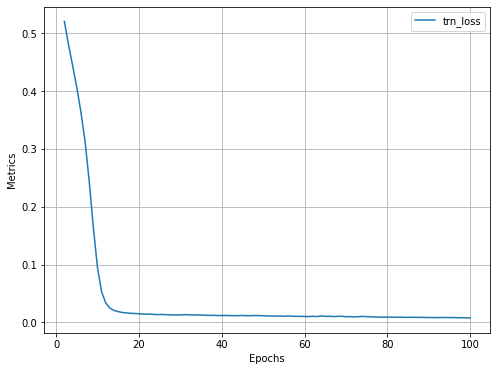

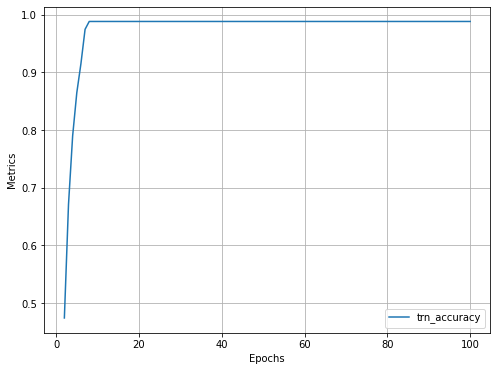

In [23]:
train_loop(
    epochs=100,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["mse"],
    weights=[1.0, 1.0], # Classes weights (Background and Foreground)
    freeze_encoder=True,
    use_lr_scheduler=True
)

Now, we run our testing method (`predict_and_evaluate`) for the trained model, using the training and testing data.

In [24]:
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)

[INFO] Training Metrics


76it [00:02, 25.68it/s]

[INFO] Avg Accuracy: 0.9879982471466064 +/- 0.011624940671026707
[INFO] Avg Dice: 0.4605263157894737 +/- 0.4984393927598897
[INFO] Avg IoU: 0.7242622661747431 +/- 0.25477011291207574


In [25]:
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

[INFO] Test Metrics


20it [00:00, 25.40it/s]

[INFO] Avg Accuracy: 0.9879522323608398 +/- 0.012367559596896172
[INFO] Avg Dice: 0.45 +/- 0.49749371855331004
[INFO] Avg IoU: 0.7189761266112328 +/- 0.2542124744341459


____

Now, we define a new model and also load FLIM weights.

In [26]:
unet = UNet(
    in_channels=3,
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0], 
    ],
    bottleneck_size=3,
    activations_path=DATA_PATH / Path("exper/FLIM_ENC_lr_scheduler")
).to(DEVICE)

load_FLIM_encoder(
    model=unet,
    arch_json=ARCH_JSON,
    weights_path=WEIGHTS_PATH,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights


However, now, we will allow to fine-tune the encoder.

EPOCH: 1.000	trn_loss: 0.521	trn_accuracy: 0.475	(2.49s - 246.34s remaining)
EPOCH: 2.000	trn_loss: 0.480	trn_accuracy: 0.674	(4.99s - 244.37s remaining)
EPOCH: 3.000	trn_loss: 0.444	trn_accuracy: 0.791	(7.49s - 242.31s remaining)
EPOCH: 4.000	trn_loss: 0.406	trn_accuracy: 0.862	(9.97s - 239.27s remaining)
EPOCH: 5.000	trn_loss: 0.364	trn_accuracy: 0.915	(12.44s - 236.32s remaining)
EPOCH: 6.000	trn_loss: 0.312	trn_accuracy: 0.974	(14.90s - 233.39s remaining)
EPOCH: 7.000	trn_loss: 0.244	trn_accuracy: 0.988	(17.35s - 230.53s remaining)
EPOCH: 8.000	trn_loss: 0.166	trn_accuracy: 0.988	(19.81s - 227.82s remaining)
EPOCH: 9.000	trn_loss: 0.096	trn_accuracy: 0.988	(22.27s - 225.16s remaining)
EPOCH: 10.000	trn_loss: 0.054	trn_accuracy: 0.988	(24.74s - 222.62s remaining)
EPOCH: 11.000	trn_loss: 0.033	trn_accuracy: 0.988	(27.19s - 220.03s remaining)
EPOCH: 12.000	trn_loss: 0.024	trn_accuracy: 0.988	(29.65s - 217.40s remaining)
EPOCH: 13.000	trn_loss: 0.021	trn_accuracy: 0.988	(32.16s - 215.2

100%|██████████████████████████████████████| 201/201 [00:00<00:00, 74600.04it/s]


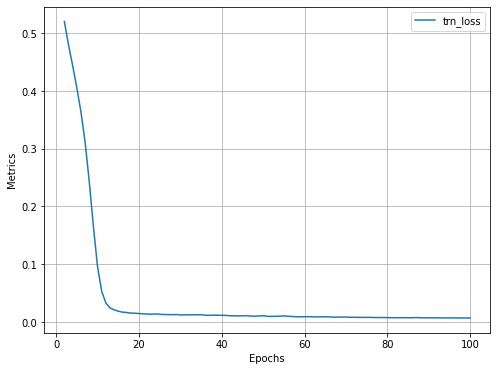

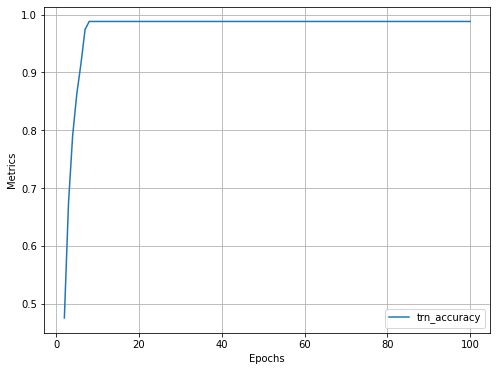

In [27]:
train_loop(
    epochs=100,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["mse"],
    weights=[1, 1], # Classes weights (Background and Foreground)
    freeze_encoder=False,
    use_lr_scheduler=True
)

Finally, we also benchmark our model:

In [28]:
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)

[INFO] Training Metrics


76it [00:02, 26.39it/s]

[INFO] Avg Accuracy: 0.9879982471466064 +/- 0.011624940671026707
[INFO] Avg Dice: 0.4605263157894737 +/- 0.4984393927598897
[INFO] Avg IoU: 0.7242622661747431 +/- 0.25477011291207574


In [29]:
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

[INFO] Test Metrics


20it [00:00, 25.44it/s]

[INFO] Avg Accuracy: 0.9879522323608398 +/- 0.012367559596896172
[INFO] Avg Dice: 0.45 +/- 0.49749371855331004
[INFO] Avg IoU: 0.7189761266112328 +/- 0.2542124744341459


Depending on the quality of the image markers, fine-tuning may improve the FLIM-Encoder. However, the learning rate scheduler plays a role in the process. 

## 10. Run inferences with FLIM-Encoder using an adaptive decoder.

Here, we will use an adaptive Decoder to segment our parasites.

First, we define an U-Net model and Load FLIM-Encoder weights:

In [30]:
unet = UNet(
    in_channels=3,
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0], 
    ],
    bottleneck_size=3,
    activations_path=DATA_PATH / Path("exper/FLIM_Adaptive_Decoder")
).to(DEVICE)

load_FLIM_encoder(
    model=unet,
    arch_json=ARCH_JSON,
    weights_path=WEIGHTS_PATH,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

unet.save_activations(0,train_dataloader)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Saving activations!


100%|███████████████████████████████████████████| 76/76 [00:16<00:00,  4.51it/s]


We define some utilitarian functions. `erase_frame` sets the frame border to zero. Some activations also actives for the frame border and could be misinterpreted as background. `get_adaptive_weight` gets weights for the activations, where activations with many activated pixels are set as background (weight=-1), and the opposite as foreground (weight=1).

In [31]:
# Zero-out frame border
def erase_frame(activation, n):
    activation[:n, :] = 0
    activation[-n: :] = 0
    activation[:, :n] = 0
    activation[:, -n:] = 0
    
    return activation

"""
Get activation weight, given the amount of voxels activated.
Background activations usually activate most of the image; hence, we set its weight as -1.
"""
def get_adaptive_weight(activation, perc_thres):
    n_elements = activation.shape[0] * activation.shape[1]
    i_max = np.max(activation)
    i_min = np.min(activation)
    if i_max != i_min:
        image = 255 * (activation - i_min) / (i_max - i_min)
    else:
        image = activation
    image = image.astype(np.uint8)
    
    threshold, _ = cv2.threshold(
        image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU
    )
    
    bin_image = image > threshold
    n_activations = np.sum(bin_image)
    
    if n_activations > (perc_thres * n_elements):
        weight = -1
    else:
        weight = 1
        
    return weight

Our adaptive Decoder works as follows:

1. We will instantiate a U-Net and load our FLIM weights
2. We start from the lowest encoder block and:
    1. For each activation, we verify if it has a background (weight = -1) or a foreground activation (weight = 1);
    2. We sum all activations into a single saliency map, using its weight (-1 or 1);
    3. Based on this saliency map, we get the coordinates of the largest contour;
    4. We repeat steps 1 to 2 for the upper layer; however, we zero activations outside the largest contour activations (avoid false positives).
3. Based on the saliency map of the first layer, we compute our metrics.

In [32]:
def adaptive_decoder(model, dataloader, image_id):
    # Get an image and pass it through the network 
    image = load_image(
        str(dataloader.dataset.images_path[image_id]),
        lab=True
    )
    image_data = dataloader.dataset.transforms(image)
    ground_truth = train_dataloader.dataset.transforms(
        ImageOps.grayscale(Image.open(train_dataloader.dataset.labels_path[image_id]))
    )
    ground_truth = ground_truth.cpu().detach().numpy()[0]
    image_data = torch.unsqueeze(image_data, dim=0)
    image_data = image_data.to(DEVICE)

    unet.to(DEVICE)
    unet(image_data)
    encoder_activations = unet.activations["encoder"]
  
    activations = encoder_activations[1].cpu().detach().numpy()[0]
    
    saliency    = np.zeros_like(activations[0])
    for activation in activations:
        activation = erase_frame(activation, 3)
        weight = get_adaptive_weight(activation, 0.1)
        saliency += weight * activation
     
    saliency[saliency < 0] = 0 # RELU
    
    # Scale to the ground truth size
    saliency = cv2.resize(saliency, dsize=(240, 240), interpolation=cv2.INTER_LINEAR)
    
    # Gets the largest contour
    # Binarizes image
    
    i_max = np.max(saliency)
    i_min = np.min(saliency)
    if i_max != i_min:
        image = 255 * (saliency - i_min) / (i_max - i_min)
        image = image.astype(np.uint8)
        threshold, _ = cv2.threshold(
        image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        image = image > threshold
        contours, hierarchy = cv2.findContours(image.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour = max(contours, key = cv2.contourArea)
        x_initial, y_initial, width, height = cv2.boundingRect(contour)
        x_final = x_initial + width
        y_final = y_initial + height
        tmp_array = np.zeros_like(saliency)
        tmp_array[y_initial:y_final, x_initial:x_final] = image[y_initial:y_final, x_initial:x_final]
        saliency = tmp_array
         
    # Computes metrics
    jaccard_index = JaccardIndex(num_classes=2, task="binary")
    accuracy = np.mean((saliency == ground_truth).astype(np.float32))
    dice = binary.dc(saliency, ground_truth)
    iou = jaccard_index(torch.Tensor(saliency).long(), torch.Tensor(ground_truth).long())
    if (np.any(ground_truth)):
        dice = binary.dc(saliency, ground_truth)
        iou = jaccard_index(torch.Tensor(saliency).long(), torch.Tensor(ground_truth).long())
    else:
        if (np.any(saliency)):
            dice = iou = 0.0
        else:
            dice = iou = 1.0
    print(f"[INFO] Accuracy: {accuracy}")
    print(f"[INFO] Dice: {dice}")
    print(f"[INFO] IoU: {iou}")
    
    plt.subplot(121)
    plt.imshow(saliency, cmap="gray")
    plt.yticks([]),plt.xticks([])
    plt.title(f"Prediction")
    plt.subplot(122)
    plt.imshow(ground_truth, cmap="gray")
    plt.yticks([]),plt.xticks([])
    plt.title(f"Ground Truth")

[INFO] Accuracy: 0.9892361164093018
[INFO] Dice: 0.6623093681917211
[INFO] IoU: 0.7421176433563232


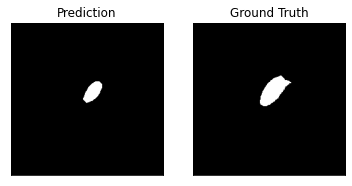

In [48]:
adaptive_decoder(
    model=unet,
    dataloader=train_dataloader, 
    image_id=45
)

## Extra - Activities

- Try different losses and Class weights (weights parameter on train_loop). Could you increase performance metrics?
- Try to improve the adaptive decoder. Could you implement any modification that increases performance metrics? And about problematic images, how would you tackle them?
- Could you apply post-processing on predicted masks to increase performance metrics (e.g., morphological operations)?
- Could you replicate the adaptive decoder to the whole dataset?